# Detecting Spam Emails Using Tensorflow in Python

Step 01: load dataset

In [3]:
import sys
!"{sys.executable}" -m pip install pandas


   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.7 MB 275.3 kB/s eta 0:00:34
   -- ------------------------------------- 0.5/9.7 MB 275.3 kB/s eta 0:00:34
   --- ---------

In [6]:
import pandas as pd
data = pd.read_csv("spam_ham_dataset.csv")

data.head(5)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


Step 2: Import Required Libraries
Before we begin let’s import the necessary libraries: pandas, numpy, tensorflow, matplotlib, wordcloud, nltk for data processing, model building, and visualization.

In [8]:
import sys
!"{sys.executable}" -m pip install numpy pandas matplotlib seaborn scikit-learn nltk wordcloud


  Using cached wordcloud-1.9.6-cp313-cp313-win_amd64.whl.metadata (3.5 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 1.2 MB/s eta 0:00:07
   --- ------------------------------------ 0.8/8.1 MB 1.1 MB/s eta 0:00:07
   ----- ---------------------------------- 1.0/8.1 MB 1.1 MB/s eta 0:00:07
   ------ --------------------------------- 1.3/8.1 MB 1.0 MB/s eta 0:00:07
   ------ --------------------------------- 1.3/8.1 MB 1.0 MB/s eta 0:00:07
   ------- -------------------------------- 1.6/8.1 MB 1.0 MB/s eta 0:00:07
   --------- ------------------------------ 1.8/8.1 MB 1.0 MB/s eta 0:00:07
   ---------- ----------------------------- 2.1/8.1 MB 991.8 kB/s eta 0:00:07
   ---------- ----------------------------- 2.1/8.1 MB 991.8 kB/s eta 0:00:07
   ---------- ----------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
#from wordcloud import WordCloud
nltk.download('stopwords')


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
import sys
!"{sys.executable}" -m pip install wordcloud

In [12]:
from wordcloud import WordCloud
print("wordcloud OK")


wordcloud OK


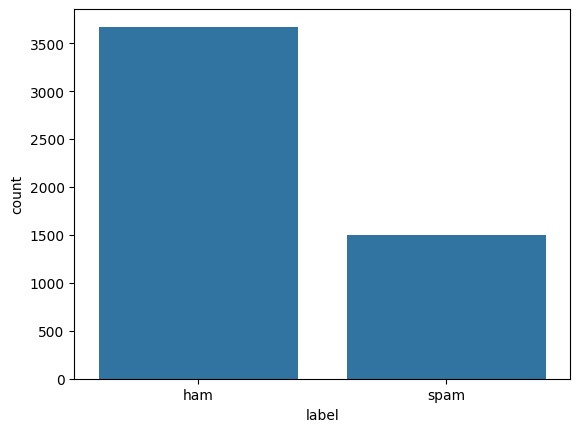

In [11]:
sns.countplot(x='label', data=data)
plt.show()

Step 3: Balance the Dataset
We can clearly see that number of samples of Ham is much more than that of Spam which implies that the dataset we are using is imbalanced. To address the imbalance we’ll downsample the majority class (Ham) to match the minority class (Spam).

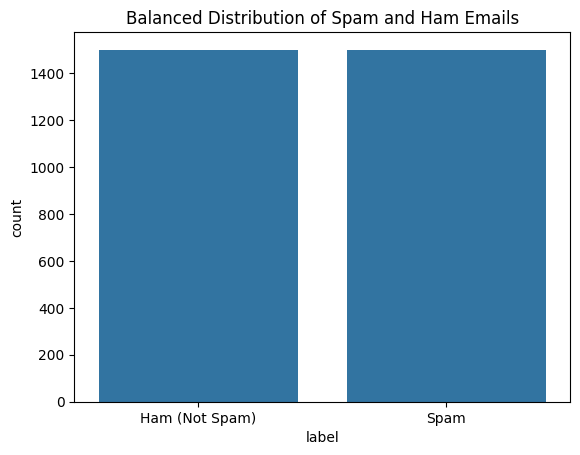

In [13]:
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

# Downsample Ham emails to match the number of Spam emails
ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=42)

# Combine balanced data
balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)

# Visualize the balanced dataset
sns.countplot(x='label', data=balanced_data)
plt.title("Balanced Distribution of Spam and Ham Emails")
plt.xticks(ticks=[0, 1], labels=['Ham (Not Spam)', 'Spam'])
plt.show()

Step 4: Clean the Text
Textual data often requires preprocessing before feeding it into a machine learning model. Common steps include removing stopwords, punctuations, and performing stemming/lemmatization.

We’ll perform the following steps:

1. Stopwords Removal
2. Punctuations Removal
3. Stemming or Lemmatization

Although removing data means loss of information we need to do this to make the data perfect to feed into a machine learning model.

In [14]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,2982,ham,: feb 01 prod : sale to teco gas processing\r\...,0
2,2711,ham,": california energy crisis\r\ncalifornia  , s...",0
3,3116,ham,: re : nom / actual volume for april 23 rd\r\n...,0
4,1314,ham,: eastrans nomination changes effective 8 / 2 ...,0


In [15]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0
1,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0
2,2711,ham,california energy crisis\r\ncalifornia  s p...,0
3,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0
4,1314,ham,eastrans nomination changes effective 8 2 0...,0


The below function is a helper function that will help us to remove the stop words.

In [16]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


Visualization Word Cloud

A word cloud is a text visualization tool that help's us to get insights into the most frequent words present in the corpus of the data.

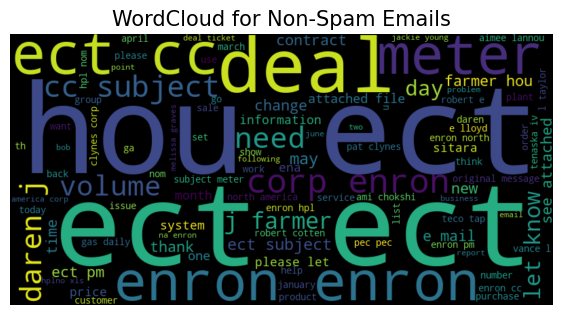

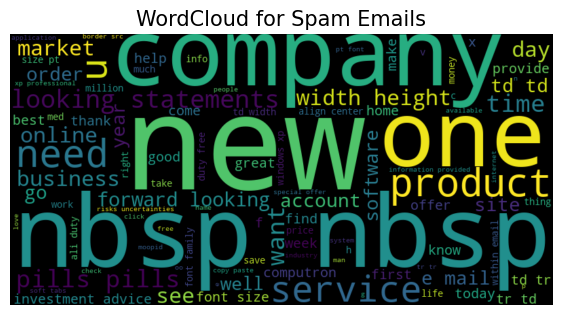

In [17]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')

Step 6: Tokenization and Padding

Machine learning models work with numbers, so we need to convert the text data into numerical vectors using Tokenization and Padding.

1. Tokenization: Converts each word into a unique integer.
2. Padding: Ensures that all text sequences have the same length, making them compatible with the model.

In [18]:

from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['text'], balanced_data['label'], test_size=0.2, random_state=42
)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_len = 100  # Maximum sequence length
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

train_Y = (train_Y == 'spam').astype(int)
test_Y = (test_Y == 'spam').astype(int)

Step 7: Define the Model

We will build a deep learning model using a Sequential architecture. This model will include:

1. Embedding Layer: Learns vector representations of words.
2. LSTM Layer: Captures patterns in sequences.
3. Fully Connected Layer: Extracts relevant features.
4. Output Layer: Predicts whether an email is spam or not.

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(tokenizer.word_index) + 1,
        output_dim=32,
        input_shape=(max_len,)   # ✅ this builds it
    ),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 32)             │       1,274,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,278,625 (4.88 MB)

 Trainable params: 1,278,625 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

Step 8: Train the Model

We train the model using EarlyStopping and ReduceLROnPlateau callbacks. These callbacks help stop the training early if the model’s performance doesn’t improve and reduce the learning rate to fine-tune the model.

In [23]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.5805 - loss: 0.6831 - val_accuracy: 0.7117 - val_loss: 0.5920 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9216 - loss: 0.2589 - val_accuracy: 0.9533 - val_loss: 0.1770 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9646 - loss: 0.1382 - val_accuracy: 0.9600 - val_loss: 0.1629 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9729 - loss: 0.1187 - val_accuracy: 0.9567 - val_loss: 0.1784 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9633 - loss: 0.1612 - val_accuracy: 0.9517 - val_loss: 0.1901 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9654 - loss: 0.1494 - val_accuracy: 0.9500 - val_loss: 0.1937 - learning_rate: 5.0000e-04


After training, we evaluate the model on the test data to measure its performance.

In [25]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9617 - loss: 0.1691 
Test Loss : 0.1690862625837326
Test Accuracy : 0.9616666436195374


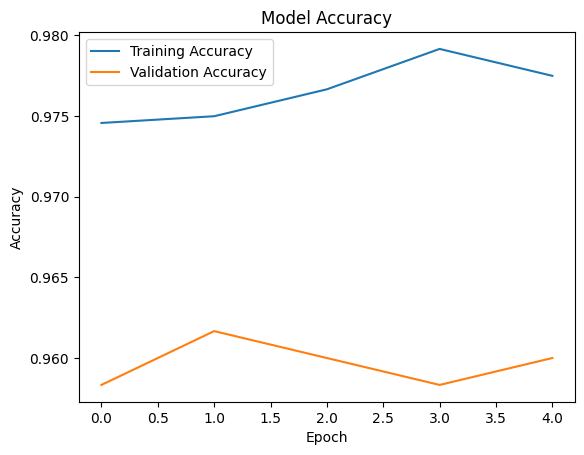

In [26]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()